# GPU Computing for Value Function Iteration in OpenCL
### Original Paper: "Tapping the Supercomputer Under Your Desk: Solving Dynamic Equilibrium Models with Graphics Processors"

## Preparing the Environment

We first import the OpenCL.jl modeule into the Julia workspace, and we make sure that the machine is equipped with a GPU device to run the task:

In [2]:
using OpenCL

cl.devices()

2-element Array{OpenCL.cl.Device,1}:
 OpenCL.Device(Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz on Apple @0x00000000ffffffff)
 OpenCL.Device(Intel(R) Iris(TM) Graphics 550 on Apple @0x0000000001024500)          

In this case the 2nd device is an Intel GPU (Iris 550): since Intel graphic cards are not programmable with the CUDA GPGPU language, we resort to OpenCL, which runs with little performance overhead on prectically *any* consumer available graphics card.

Let us create an OpenCL compute context i.e. initialize an environment for OpenCL computation:

In [3]:
# device, ctx, queue = cl.create_compute_context();

## Creating the Kernel

The key component in any GPGPU program is the so-called **kernel**: a kernel is nothing more than a small, compact routine that instead of running on the CPU, that is **serially**, is dispatched to the GPU by the OpenCL program and run **at the same time** by all available cores.

The downside of the GPU is that all of its cores are "tied together", which means only tasks that can be split into indipendent, small-scale problems can benefit from being run on the GPU. In fact, most of the complexity in GPGPU computing is usually connected to the correct and most efficient orchestration of the CPU and the GPU.

Let us now define the **Value Function Iteration** algorithm as an OpenCL kernel:

In [4]:
vfi_source = "
#pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable

__kernel void gpuvfi( __global float *w,
                      __global int *iters,
                      __global const float *grid,
                      float const w_lb,
                      float const w_ub,
                      ushort const max_iter,
                      float const precision ) 
    {
      
        int gid = get_global_id(0);

        int it = 0;

        float alpha = 0.5f;
        float beta = 0.7f;

        float phi = 0.618033f;
        
        float grid_p = grid[gid];

        // float lb = w_lb;
        // float up = w_ub;
        // float b = pow(grid_p, alpha);

        float a = 0.01f;
        float b = pow(grid_p, alpha);

        // a = lb - (ub-lb)/(2*phi-1)*phi;
        // b += lb + (ub-lb)/(2*phi-1)*phi;

        float w1 = 0;
        float w2 = 0;
        
        float w_prev = 0;
        float w_temp = w_prev;

        for(int k = 0; k < max_iter; k++) {

            w_prev = w_temp;

            a = 0.01f;
            b = pow(grid_p, alpha);

            w1 = log(powr(grid_p, alpha) - (a+(b-a)*(1-phi)))  + beta*w_prev;
            w2 = log(powr(grid_p, alpha) - (a+(b-a)*phi)) + beta*w_prev;

            // Optimize the value function by the Golden search algorithm:
        
            // int ii = 0;
            
            for(int i = 0; i < 100; i++) {

                if (w1 > w2) {
                
                    b = a+(b-a)*phi;
                    w2 = log(powr(grid_p, alpha) - (a+(b-a)*phi)) + beta*w_prev;
                
                } else {

                    a = a+(b-a)*(1-phi);
                    w1 = log(powr(grid_p, alpha) - (a+(b-a)*(1-phi))) + beta*w_prev;

                }
                
                // ii++;
                
                if (fabs(a - b) <= 0.0001)
                   break;

            } // end of optimization;

            w_temp = w1;

            it++;

            // Check iteration convergence:

            if (fabs(w_temp - w_prev) <= 0.00001)
                break;

        } // end of value function iteration;

        w[gid] = w_temp;

        iters[gid] = it;
    
    }
";



vfi_source__ = "
#pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable

__kernel void gpuvfi( __global float *w,
                      __global int *iters,
                      __global const float *grid,
                      float const w_lb,
                      float const w_ub,
                      ushort const max_iter,
                      float const precision ) 
    {
      
        int ii = 0;
            
            for(int i = 0; i < 100; i++) {

                if (w1 > w2) {
                
                    b = a+(b-a)*phi;
                    w2 = log(powr(grid_p, alpha) - (a+(b-a)*phi)) + beta*w_prev;
                
                } else {

                    a = a+(b-a)*(1-phi);
                    w1 = log(powr(grid_p, alpha) - (a+(b-a)*(1-phi))) + beta*w_prev;

                }
                
                ii++;
                
                if (fabs(a - b) <= 0.00001)
                    break;

            } // end of optimization;
    
    }
";

vfi_correct = "
#pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable

__kernel void gpuvfi( __global float *V0,
                      __global float *V,
                      __global const float *grid) 
    {
      
        int gid = get_global_id(0);

        float alpha = 0.5f;
        float beta = 0.7f;
        
        float grid_p = grid[gid];

        float V1 = 0;
        float V2 = 0;

        /* V1 = log(powr(grid_p, alpha) - grid[0])  + beta*V0[0];

        for(int i = 1; i < gid; i++) {

            // V2 = log(powr(grid_p, alpha) - grid[i])  + beta*V0[i];

            if (V2 > V1) { V1 = V2; }

        }

         V[gid] = V1; */
    
    }
";

In [5]:
#=

a = rand(Float32, 50_000)
b = rand(Float32, 50_000)

device, ctx, queue = cl.create_compute_context()

a_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf=a)
b_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf=b)
c_buff = cl.Buffer(Float32, ctx, :w, length(a))
p = cl.Program(ctx, source=vfi_source) |> cl.build!
k = cl.Kernel(p, "sum")

queue(k, size(a), nothing, a_buff, b_buff, c_buff)

r = cl.read(queue, c_buff)

if isapprox(norm(r - (a+b)), zero(Float32))
    info("Success!")
else
    error("Norm should be 0.0f")
end
=#


In [6]:

lb = 0.001;
ub = 10;

grid_size = 1000;

grid_w = Array{Float32}(collect(linspace(lb, ub, grid_size)));

#=
w = Array{Float32}(zeros(size(grid_w)));
it = Array{Int16}(zeros(size(grid_w)));
=#

1000-element Array{Float32,1}:
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1 
  0.11
  0.12
  0.13
  ⋮   
  9.89
  9.9 
  9.91
  9.92
  9.93
  9.94
  9.95
  9.96
  9.97
  9.98
  9.99
 10.0 

In [7]:
#=
w_buff = cl.Buffer(Float32, ctx, :w, length(w));
it_buff = cl.Buffer(Int16, ctx, :w, length(it));

grid_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf = grid_w);
#lb_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf = lb)
#ub_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf = ub)

p = cl.Program(ctx, source = vfi_source) |> cl.build!
krn = cl.Kernel(p, "gpuvfi")
=#

In [8]:
# queue(krn, size(w), nothing, w_buff, it_buff, grid_buff, 0.1, 10 , 1000, 0.0001)

# cl.call(queue, krn, length(w), nothing, )

In [9]:
# iters = cl.read(queue, it_buff);
# r = cl.read(queue, w_buff)

In [41]:
function opencl_vfi(grid_::Array{Float32}, lowb_::Any, upb_::Any, maxiter_::Any, prec_::Any)
    
    device, ctx, queue = cl.create_compute_context();
    
    vfi_cl = readstring(joinpath(pwd(), "vfi_correct.cl"));
    
    # grid = Array{Float32}(zeros(size(grid_)));
    
    V0 = Array{Float32}(zeros(size(grid_)));
    V = Array{Float32}(zeros(size(grid_)));
    
    # it = Array{Int16}(zeros(size(grid)));
    
    grid_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf = grid_);
    
    # w_buff = cl.Buffer(Float32, ctx, :w, length(grid_));
    V0_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf = V0);
    V_buff = cl.Buffer(Float32, ctx, :w, length(V));
    # V_buff = cl.Buffer(Float32, ctx, (:r, :copy), hostbuf = V);
    
    # it_buff = cl.Buffer(Int16, ctx, :w, length(grid_));

    p = cl.Program(ctx, source = vfi_cl) |> cl.build!  # Using the CORRECT kernel;
    krn = cl.Kernel(p, "gpuvfi")
    
    V0 = ones(size(V0));
    V0_ = zeros(size(V0));
    
    it = 0;
    
    while ( norm(V0 - V) > prec_ && it < maxiter_)
        
        copy!(V0, V);
    
        # queue(krn, size(grid_), nothing, V0_buff, V_buff, grid_buff, 1000);
        
        # queue(krn, size(grid_), nothing, V_buff, V0_buff, grid_buff)
        
        # queue(krn, size(grid_), nothing, V_buff, V0_buff, grid_buff, 
        #                                 Float32(lowb_), Float32(upb_), UInt16(maxiter_), Float32(prec_))
        #                         0.1, 10 , 1000, 0.0001)
    
        # iters = cl.read(queue, it_buff);
        
        krn[queue, size(grid_)](V0_buff, V_buff, grid_buff, 1000)
        
        V = cl.read(queue, V_buff);
        
        V0_ = cl.read(queue, V0_buff);
        
        cl.copy!(queue, V0_buff, V_buff);
        
        # cl.copy!(queue, V0_buff, Array{Float32}(4.*ones(size(V0))));
        
        it += 1;
        
    end
    
    return V, it
    
    # 
    
end

opencl_vfi (generic function with 1 method)

In [45]:
using Optim
using Interpolations

function cpu_vfi(grid_::Array{Float32}, lowb_::Any, upb_::Any, maxiter_::Any, prec_::Any)
    
    w_prev = ones(size(grid_));
    w_ = zeros(size(grid_));
    
    alpha = 0.5;
    beta = 0.7;
    
    it = 0;
    
    while ( sum(abs.(w_prev - w_)) > prec_ && it < maxiter_ )
        
        w_prev = copy(w_);
        
        # itp = interpolate(w_prev, BSpline(Linear()), OnGrid());
        # sitp = scale(itp, linspace(lb, ub, length(grid_)));
        
        for (i, point_i) in enumerate(grid_)
    
            # V(x) = -( log.(x) + beta*(point_i - x).^alpha );
            #= V(x) = -( log(point_i^alpha - x) + beta*sitp[x] );
            
            res = optimize(V, (lowb_/100), point_i^alpha);
            w_[i] = - res.minimum; =#
            
           w_max = -Inf;
            for (j, point_j) in enumerate(grid_)
                cons = (grid_[i].^alpha - point_j);
                if cons > 0
                    w_max = max(w_max, (log(cons) + beta*w_prev[j]));
                end
            end

            w_[i] = w_max;
            
        end
        
        it += 1;

    end

    return w_, it
     
    
end

cpu_vfi (generic function with 1 method)

## Comparing algorithm speed

In [97]:
@time w_gpu, it_gpu = opencl_vfi(grid_w, lb, ub, 1000, 0.00001)

  0.096610 seconds (2.92 k allocations: 858.281 KiB)


(Float32[-6.87141, -6.32983, -6.01895, -5.79714, -5.62508, -5.48628, -5.36702, -5.26344, -5.17375, -5.09187  …  -1.55617, -1.55539, -1.55462, -1.55384, -1.55306, -1.55229, -1.55152, -1.55074, -1.54997, -1.5492], 45)

In [98]:
@time w_cpu, it_cpu = cpu_vfi(grid_w, lb, ub, 1000, 0.00001)

  1.898444 seconds (176 allocations: 1.310 MiB)


([-6.87141, -6.32984, -6.01895, -5.79714, -5.62508, -5.48628, -5.36702, -5.26344, -5.17375, -5.09187  …  -1.55617, -1.55539, -1.55462, -1.55384, -1.55306, -1.55229, -1.55152, -1.55074, -1.54997, -1.5492], 55)

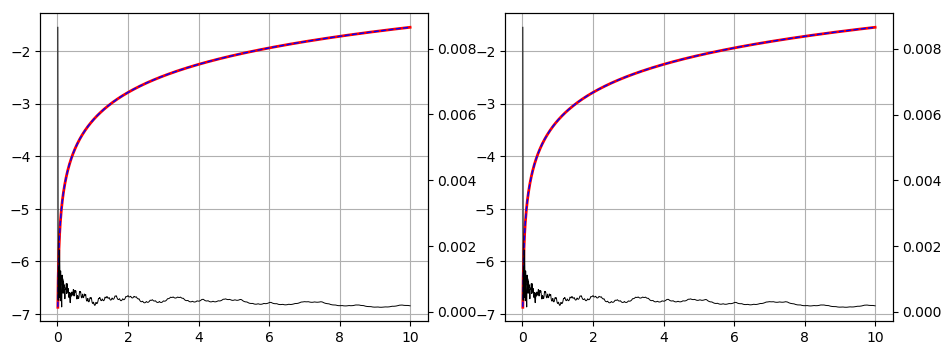

In [70]:
alpha = 0.5;
beta = 0.7;
ab = alpha*beta;
y = log(1-alpha*beta)/(1-beta) + (alpha*beta*log(alpha*beta))/((1-beta)*(1-alpha*beta)) + alpha/(1-alpha*beta)*log.(grid_w);
z = alpha/(1-ab)*log.(grid_w);

error_gpu = abs.((y-w_gpu)./(1 + abs.((y-w_gpu))));
error_cpu = abs.((y-w_cpu)./(1 + abs.((y-w_cpu))));

using PyPlot

fig = figure(figsize=(11,4));

ax_a = subplot(121);

ax_a1 = twinx(ax_a)

ax_a[:plot](grid_w, w_gpu, "r-", linewidth=2);
ax_a[:plot](grid_w, y, "b--", linewidth=1);
# ax_a1[:plot](grid_w[1:2:end], it_gpu[1:2:end], "g-", linewidth=1.5);
ax_a1[:plot](grid_w, error_gpu, "k", linewidth=0.7);
ax_a[:grid](true);

ax_b = subplot(122);

ax_b1 = twinx(ax_b)

ax_b[:plot](grid_w, w_cpu, "r-", linewidth=2);
ax_b[:plot](grid_w, y, "b--", linewidth=1);
# ax_b1[:plot](grid_w[1:end], it_cpu*ones(size(grid_w)), "g--", linewidth=1.5);
ax_b1[:plot](grid_w, error_cpu, "k", linewidth=0.7);
ax_b[:grid](true);

In [107]:
av_gpu_time = 0;
av_cpu_time = 0;

repeats = 3;

for i in 1:repeats
    
    t_gpu = @elapsed opencl_vfi(grid_w, lb, ub, 1000, 0.0001)
    t_cpu = @elapsed cpu_vfi(grid_w, lb, ub, 1000, 0.0001)
    
    av_gpu_time += t_gpu/repeats;
    av_cpu_time += t_cpu/repeats;
    
end

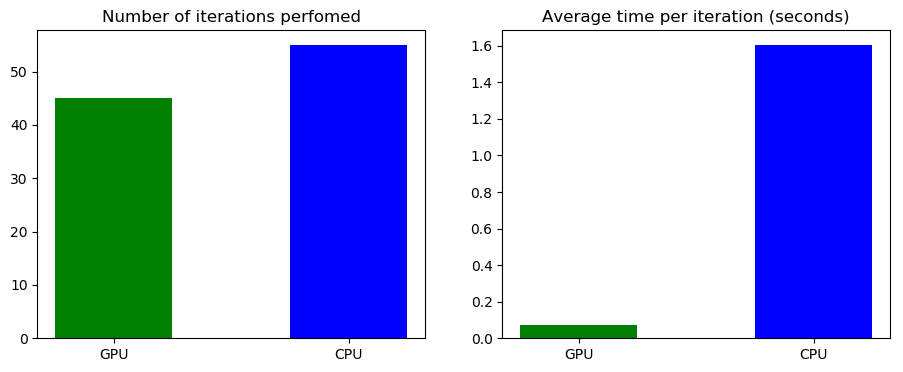

In [126]:
using PyPlot;

fig, ax = subplots(figsize=(11,4));

ax_a = subplot(121)

bar([1, 2], [it_gpu, it_cpu], tick_label=["GPU", "CPU"], color=["g", "b"], width=0.5);
title("Number of iterations perfomed");

ax_b = subplot(122)

bar([1, 2], [av_gpu_time, av_cpu_time], tick_label=["GPU", "CPU"], color=["g", "b"], width=0.5);
title("Average time per iteration (seconds)");
